<a href="https://colab.research.google.com/github/Mountagha/fromZeroToHero/blob/main/makemore3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-04-28 09:34:46--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-04-28 09:34:46 (7.21 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open("names.txt", "r").read().splitlines()

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3
def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for c in w + '.':
      idx = stoi[c]
      X.append(context)
      Y.append(idx)
      # print(f"{''.join(itos[x] for x in context)} --> {c}")
      context = context[1:] + [idx]
    
  x = torch.tensor(X)
  y = torch.tensor(Y)
  print(x.shape, y.shape)
  return x, y

In [ ]:
# training/validation/test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vector
n_hidden = 200 # the number of the neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #0.2
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


paramaters = [C, W1, W2, b2, bngain, bnbias]

In [ ]:
print(sum(p.nelement() for p in paramaters)) # number of parameters in total
for p in paramaters:
  p.requires_grad = True

12097


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
  # minibatch construct
  idx = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[idx], Ytr[idx]

  # forward pass
  emb = C[Xb] # embed the charactesr into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  
  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 + bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  for p in paramaters:
    p.grad = None
  loss.backward()

  #update 
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 # learning rate decay
  for p in paramaters:
    p.data += -lr * p.grad
  
  # tracks stats
  if i % 10000 == 0: # print every once in a while
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())


      0/ 200000: 3.3098
  10000/ 200000: 2.1441
  20000/ 200000: 2.4131
  30000/ 200000: 2.2964
  40000/ 200000: 2.3262
  50000/ 200000: 2.4677
  60000/ 200000: 2.1935
  70000/ 200000: 2.4167
  80000/ 200000: 1.9388
  90000/ 200000: 2.4100
 100000/ 200000: 2.4649
 110000/ 200000: 1.8955
 120000/ 200000: 2.4402
 130000/ 200000: 1.8761
 140000/ 200000: 2.3596
 150000/ 200000: 2.4651
 160000/ 200000: 2.3253
 170000/ 200000: 1.9825
 180000/ 200000: 2.2242
 190000/ 200000: 2.3712


In [ ]:
bnmean_running

tensor([[-2814.7651,  -851.4210, -1958.1954,  1366.1089,  1012.9269,  1686.3059,
          1528.2068, -1211.2737,  1130.7435,  1382.5817, -1576.2104, -2323.9788,
          -130.1381,  -763.6508,  -629.0767, -1167.3021,  1229.4875, -2477.3450,
          -971.9485,   733.2051,   737.6570,   132.4354,   151.3711,   297.0123,
           982.8596,  1617.5698,  1075.4226,  -311.3607,   778.4041,  1934.8469,
           -94.4994, -2381.7183,   738.2890,   376.1888, -1021.8742,  -720.9062,
         -2487.9426,   889.3425,    52.1734,   231.2552,   -52.1862, -1492.2726,
            43.0780,   375.6958,   653.7276,  -470.8889,  1370.2954,  -531.7207,
          1428.8884,  1268.6168,  1211.2970,   600.5703,  1700.2738,   651.3436,
          1387.6548, -2411.6279, -1105.9146,  -157.8978,  2100.7227, -1341.7784,
         -1356.6287,  1089.6509,   810.1582,   -27.1941,  1210.9825,  1138.9514,
          -689.2476,  1786.0331,  -659.4679,  -174.1197,  -626.9073,   734.8086,
          -571.2733,  -549.5

In [ ]:
# Calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
bnmean

tensor([[-2.8268, -0.8613, -1.9672,  1.3835,  1.0190,  1.7061,  1.5097, -1.2344,
          1.1298,  1.3848, -1.5694, -2.3307, -0.1273, -0.7274, -0.6003, -1.1644,
          1.2480, -2.4817, -1.0072,  0.7507,  0.7377,  0.1339,  0.1636,  0.3026,
          0.9755,  1.6368,  1.0834, -0.2802,  0.7952,  1.9307, -0.0884, -2.3865,
          0.7347,  0.3660, -1.0370, -0.7432, -2.5053,  0.9020,  0.0538,  0.2469,
         -0.0695, -1.4984,  0.0715,  0.3553,  0.6491, -0.5014,  1.3692, -0.5520,
          1.4446,  1.2525,  1.2283,  0.5825,  1.6746,  0.6552,  1.3932, -2.4424,
         -1.0936, -0.1506,  2.1064, -1.3428, -1.3697,  1.0809,  0.8011, -0.0488,
          1.2121,  1.1465, -0.6760,  1.7871, -0.6563, -0.1829, -0.6064,  0.7235,
         -0.5684, -0.5531, -2.4864,  0.4877,  1.0676,  0.0338,  0.4001,  0.8185,
          0.3392,  1.7497,  1.2536,  0.5524,  0.3534, -0.4684, -0.2125, -0.0799,
          0.0421, -0.4130, -1.2603,  0.8631, -1.1232, -1.2177, -1.6796,  0.4855,
          0.4602, -1.3125,  

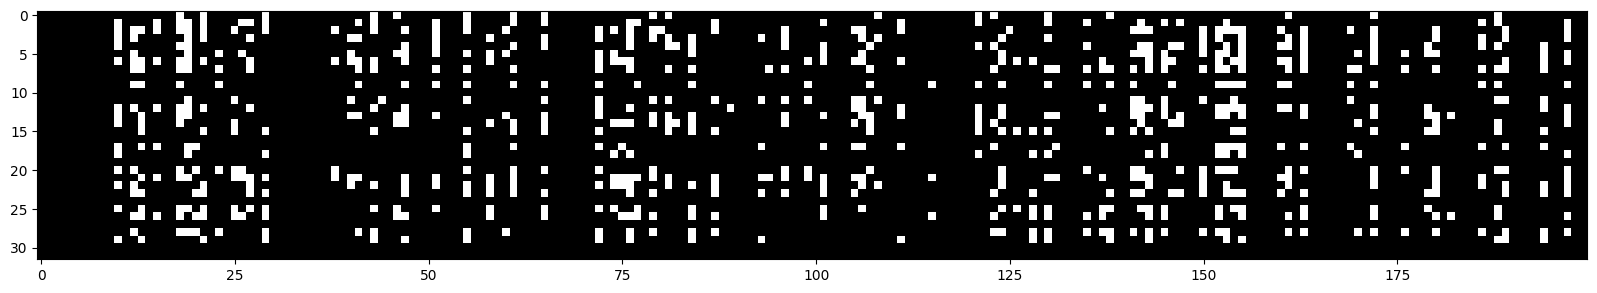

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

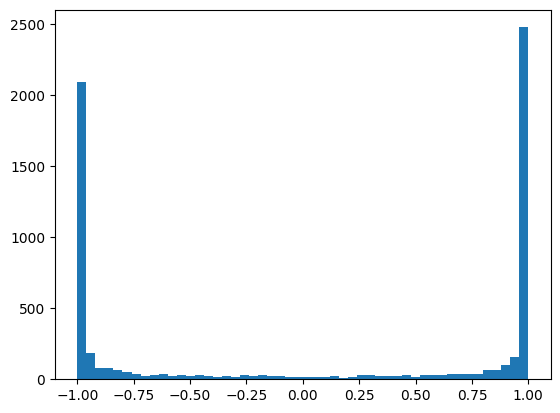

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

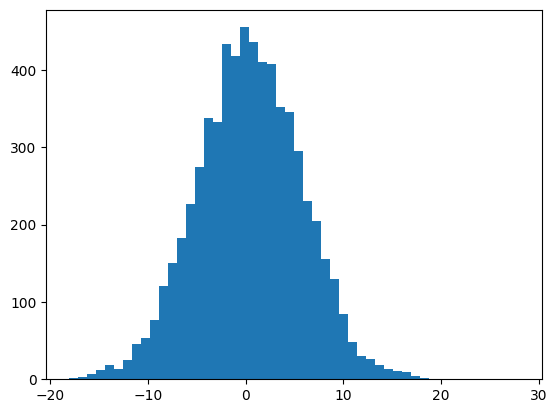

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

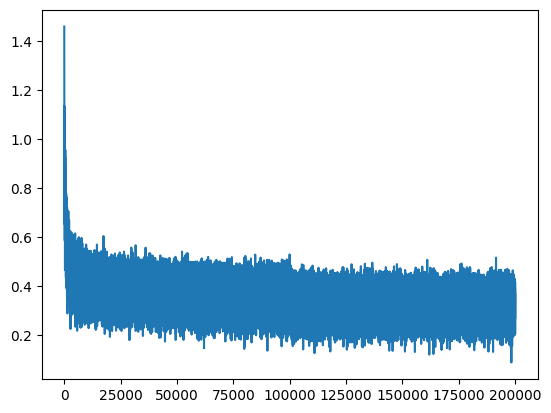

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x] # [N, block_size, n_embd]
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.0883595943450928
val 3.114927053451538


In [ ]:
# text generation.
g = torch.Generator().manual_seed(32084209852)

context = [0] * block_size


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147482647 + 10)
for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ....
  while True:
    # forward pass the neural network
    emb = C[torch.tensor([context])] # (1, block_size, n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, generator=g).item()
    # Shift the context window and track the samples
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break
  print(''.join(itos[i] for i in out))

joe.
nef.
maykalee.
lamastinnalyn.
jerotenco.
dhon.
yushamoura.
faishawgenta.
miyan.
vestyn.
hem.
kiyah.
niala.
marist.
dalima.
ema.
zecia.
gashishano.
noentley.
adra.
